In [218]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импорт библиотеки для поиска координат по адресу
from geopy.geocoders import Nominatim

# импорт библиотеки для тональности текста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
# инструмент для создания и обучения модели  
from sklearn.ensemble import RandomForestRegressor 
# инструменты для оценки точности модели 
from sklearn import metrics 

# Загружаем статистические тесты
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

# инструмент для кодирования признаков
import category_encoders as ce 

# инструмент для нормализации признаков
from sklearn import preprocessing

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [219]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [220]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [221]:
# Подгрузим наши данные из соревнования
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

Ознакомимся с датасетами df_train, df_train и submission.

In [222]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [223]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [224]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [225]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [226]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [227]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [228]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [229]:
data.info()
print('-' * 75)
print(f'Размерность датафрейма: {data.shape[0]} строк и {data.shape[1]} столбцов.')
print('-' * 75)
print('Пропущенные значения:')
data.isnull().sum().sort_values().nlargest(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

lat              3268
lng              3268
hotel_address       0
dtype: int64

### <center>Расшифровка названий столбцов датафрейма.</center>

hotel_address — адрес отеля;

review_date — дата, когда рецензент разместил соответствующий отзыв;

average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

hotel_name — название отеля;

reviewer_nationality — страна рецензента;

negative_review — отрицательный отзыв, который рецензент дал отелю;

review_total_negative_word_counts — общее количество слов в отрицательном отзыв;

positive_review — положительный отзыв, который рецензент дал отелю;

review_total_positive_word_counts — общее количество слов в положительном отзыве.

reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;

total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;

total_number_of_reviews — общее количество действительных отзывов об отеле;

tags — теги, которые рецензент дал отелю;

days_since_review — количество дней между датой проверки и датой очистки;

additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.

lat — географическая широта отеля;

lng — географическая долгота отеля.

# <center> Заполнение пропусков. </center>

Пропуски в признаках ['lat'] и ['lng'] образовались, так как в адресах отеля не загрузились специфические латинские символы не характерные для английского языка. Например, "ß" из слова "Straße" (нем.). Поэтому, координаты будем брать на основании данных о стране, городе и почтовом индексе. Это поможет идентифицировать территорию.

In [230]:
# Вариант 1: если geocoder будет работать 
empty_coordinates = list(data[(data.lat.isna() == True) | (data.lng.isna() == True)].hotel_address.unique())

#empty_coordinates_df =  pd.DataFrame({'hotel_address' : empty_coordinates})

geolocator = Nominatim(user_agent="Tester") # Создаем объект геолокатор
def get_coordinates(address):
    '''Функция запроса координат по адресу (индекс, город, страна)'''
    address = str(address.split()[-3:-1])
    query = geolocator.geocode(address,  timeout=1000)
    return pd.Series({'lat': query.latitude, 
                      'lng': query.longitude})

In [231]:
# Заполним пропуски в столбцах широты и долготы, если они есть
''''data[['lat', 'lng']] = data.hotel_address.apply(lambda x: x if x not in empty_coordinates
                                                else get_coordinates(x))'''

"'data[['lat', 'lng']] = data.hotel_address.apply(lambda x: x if x not in empty_coordinates\n                                                else get_coordinates(x))"

In [232]:
# Вариант 2 : продублируем датафрейм вручную, если geocoder не сработает в Kaggle

empty_coordinates_df =  pd.DataFrame({
                                      'hotel_address': 
     ['Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
     '23 Rue Damr mont 18th arr 75018 Paris France',
     'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
     'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
     '4 rue de la P pini re 8th arr 75008 Paris France',
     'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
     'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
     'Bail n 4 6 Eixample 08010 Barcelona Spain',
     'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
     'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
     'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
     'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
     '20 Rue De La Ga t 14th arr 75014 Paris France',
     'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
     'Sep lveda 180 Eixample 08011 Barcelona Spain',
     'Pau Clar s 122 Eixample 08009 Barcelona Spain',
     'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria'],
                                      'lat': [48.2083537, 48.8588897,
    48.2083537, 48.2083537,48.8588897, 48.2083537, 48.2083537, 
    41.39148296298701,48.2083537,48.2083537, 48.2083537, 48.2083537,
    48.8588897, 48.2083537, 41.38441083131313, 41.394770453312304,
    48.2083537],
                                      'lng': [16.3725042, 2.3200410217200766,
    16.3725042, 16.3725042, 2.3200410217200766, 16.3725042, 16.3725042, 
    2.174624973593074,16.3725042,16.3725042,16.3725042,16.3725042,
    2.3200410217200766,16.3725042,2.1589604974747476,2.169310102523659,
    16.3725042]
    })

### Создадим журнал для широты и долготы, где ключ - адрес отеля и обновим признак
latitudes = {}
longitudes = {}

for index in range(17):
    latitudes[empty_coordinates_df.loc[index][0]] = empty_coordinates_df.loc[index][1]
    longitudes[empty_coordinates_df.loc[index][0]] = empty_coordinates_df.loc[index][2]

###
unique_addresses = list(data.hotel_address.unique())

for address in unique_addresses:
    if address not in empty_coordinates:
        latitudes[address] = data[data.hotel_address == address]['lat'].iloc[0]
        longitudes[address] = data[data.hotel_address == address]['lng'].iloc[0]

###
# Перезаполним столбцы с пропусками
data['lat'] = data.hotel_address.apply(lambda x: latitudes[x])
data['lng'] = data.hotel_address.apply(lambda x: longitudes[x])
    

# <center> Преобразование признаков. </center>

Переведем признак ['review_date'], а также выделим в отдельные признаки дату и год.

In [233]:
data['review_date'] = pd.to_datetime(data['review_date'])
data['month'] = data['review_date'].dt.month
data['day_of_week'] = data['review_date'].dt.dayofweek

Создадим отдельный признак о местонахождении отеля. В нашем случае лучше взять информацию о городе. Если выделить страну и город, эти 2 величины коррелируют со значением коффициента 1, что говорит о положительной линейной взаимосвязи и модель работает хуже.

In [234]:
def get_location(address):
    location_list = ['London', 'Barcelona', 'Paris', 'Amsterdam', 'Vienna', 'Milan']
    for location in location_list:
        if location in address:
            return location 

data['location'] = data.hotel_address.apply(get_location)

Переведем в числовой формат количество дней между датой проверки и датой очистки.

In [235]:
data['days_since_review'] = data.days_since_review.apply(lambda x: x.split()[-2])
data['days_since_review'] = data.days_since_review.astype(int)

Проанализируем тексты отзывов с помощью библиотеки NLTK и создадим дополнительные признаки: 'negative_tone', 'neutral_tone' и 'positive_tone'.

In [236]:
sent_analyzer = SentimentIntensityAnalyzer()

def get_text_tone(x):
    '''Функция для расчета доли негативных, позитивный и нейтральных слов в тексте'''
    tone = sent_analyzer.polarity_scores(x)
    return pd.Series({'negative_tone': tone['neg'],
                      'neutral_tone':  tone['neu'],
                      'positive_tone': tone['pos']})

In [237]:
data['negative_review'] = data.negative_review.apply(lambda x: '' if 'No Negative' in x else x)
data['positive_review'] = data.positive_review.apply(lambda x: '' if 'No Positive' in x else x)
data['review_text'] = data['negative_review'] + ''+ data['positive_review']

data[['negative_tone', 'neutral_tone', 'positive_tone']] = data.review_text.apply(get_text_tone)

Составим портрет гостя отеля.

In [238]:
data.reviewer_nationality.value_counts(normalize=True)

 United Kingdom               0.475524
 United States of America     0.068711
 Australia                    0.042048
 Ireland                      0.028749
 United Arab Emirates         0.019845
                                ...   
 Comoros                      0.000002
 Anguilla                     0.000002
 Tuvalu                       0.000002
 Cape Verde                   0.000002
 Palau                        0.000002
Name: reviewer_nationality, Length: 227, dtype: float64

In [239]:
unique_tags = data.copy()
unique_tags['tags'] = unique_tags['tags'].apply(lambda x: x.strip('[]'))
unique_tags = unique_tags.tags.str.cat(sep = ',').split(',')

def unique_tags_cleaning(data):
    new_list = []
    for element in data:
        element = element.strip(' ')
        new_list.append(element)
    new_list = set(new_list)
    return new_list

unique_tags = unique_tags_cleaning(unique_tags)
print(len(unique_tags),'уникальных тегов представлено в наборе данных.')

2428 уникальных тегов представлено в наборе данных.


# <center>Преобразование признаков.</center>

Закодируем признак местонахождения отеля, месяца и года.

In [240]:
data = pd.get_dummies(data, columns=['location'])

In [241]:
ord_encoder = ce.OrdinalEncoder()
data_month = ord_encoder.fit_transform(data['month'])
data_day_of_week = ord_encoder.fit_transform(data['day_of_week'])
data['month']= data_month
data['day_of_week']= data_day_of_week

Нормализуем признаки ['additional_number_of_scoring'] и ['days_since_review'] для понижения размерности.

In [242]:
df = data.copy()

col_names = ['additional_number_of_scoring','days_since_review']
df = pd.DataFrame(data=df, columns=col_names)
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# кодируем исходный датасет
df_r = r_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_r = pd.DataFrame(df_r, columns=col_names)


# Заменим признаки на нормализованные
data['additional_number_of_scoring'] = df_r['additional_number_of_scoring']
data['days_since_review'] = df_r['days_since_review']

Удалим столбцы с типом "object'.

In [243]:
data.drop(['hotel_address','review_date','hotel_name','reviewer_nationality','negative_review','positive_review',
           'tags','review_text'], axis=1, inplace=True)

# <center>Отбор признаков.</center>

<AxesSubplot:>

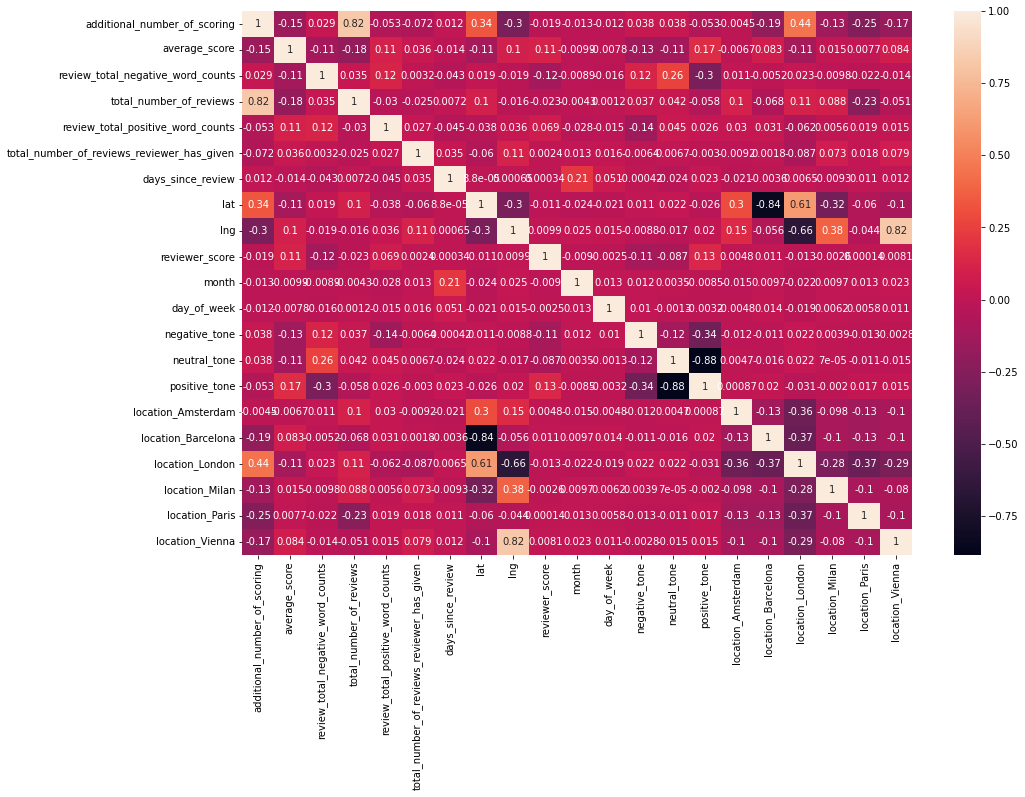

In [244]:
fig = plt.subplots(figsize=(15, 10))
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

Высокая корреляция наблюдается между 4 парами признаков: ['total_number_of_reviews'] и ['additional_number_of_scoring'],
['year'] и ['days_since_review'], ['lat'] и ['location_Barcelona'], ['lng'] и ['location_Vienna'], а также ['positive_tone'] и ['neutral_tone'].

In [245]:
#data.drop(['total_number_of_reviews','neutral_tone'], axis=1, inplace=True)

In [246]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [247]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [248]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 21), (386803, 21), (386803, 20), (309442, 20), (77361, 20))

Оценим влияние призаков на модель.

In [249]:
# непрерывные признаки
num_cols = ['additional_number_of_scoring',
            'average_score',
            'review_total_negative_word_counts',
            'review_total_positive_word_counts',
            'total_number_of_reviews',
            'total_number_of_reviews_reviewer_has_given',
            'days_since_review',
            'lat', 
            'lng',
            'negative_tone', 
            'positive_tone',
            'neutral_tone'
]

# категориальные признаки
cat_cols = ['month', 
            'day_of_week',
            'location_Amsterdam',
            'location_Barcelona', 
            'location_London', 
            'location_Milan',
            'location_Paris', 
            'location_Vienna'
]

<AxesSubplot:>

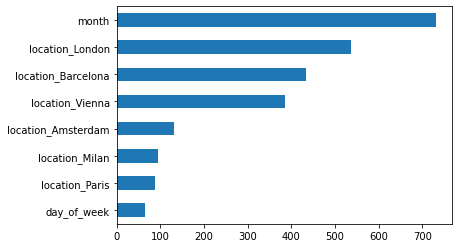

In [250]:
y=y.astype('int')
# Используем Хи-квадрат
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

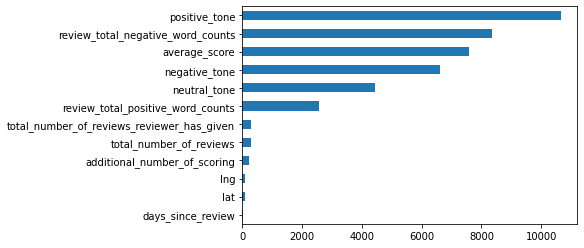

In [251]:
# Используем тест ANOVA
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [252]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [253]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished


Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются.

In [254]:
# Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную процентную ошибку предсказанных значений 
# в отношении фактических
def mape_func(y_actual, y_predict):
    mape = np.mean(np.abs((y_actual - y_predict)/y_actual) * 100)
    return mape
print('MAPE:', mape_func(y_test, y_pred))

MAPE: 12.859662938997515


Следовательно, средняя разница между прогнозируемым значением и фактическим значением составляет приблизительно 12,86%.

Смотрим самые важные признаки, которые внесли основной вклад в модель.

<AxesSubplot:>

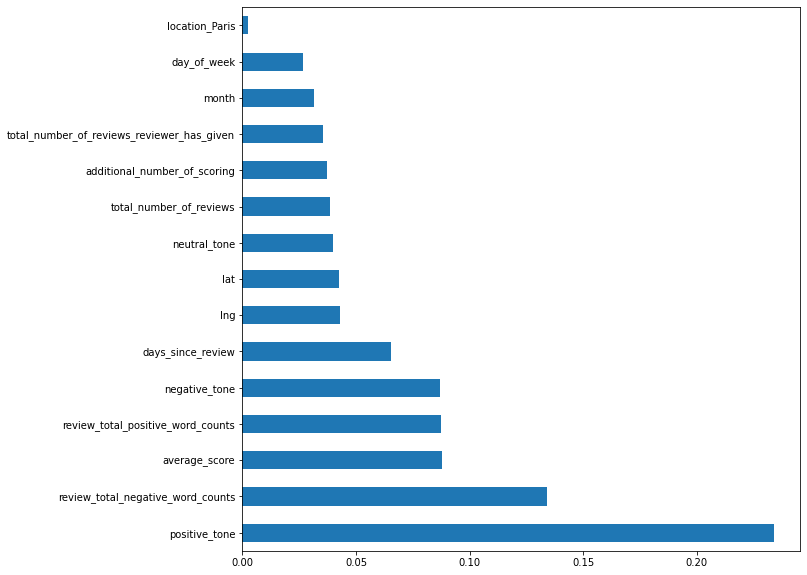

In [255]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# <center>Формируем сабмишн файл.</center>

In [256]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,...,day_of_week,negative_tone,neutral_tone,positive_tone,location_Amsterdam,location_Barcelona,location_London,location_Milan,location_Paris,location_Vienna
23889,1.044807,7.8,170,3867,0,12,-0.173295,51.494231,-0.185114,0.0,...,5,0.029,0.837,0.134,0,0,1,0,0,0
41434,0.574338,9.0,25,2750,22,2,0.286932,51.510462,-0.079550,0.0,...,4,0.055,0.816,0.128,0,0,1,0,0,0
30032,0.059063,8.9,0,4016,17,3,-0.375000,48.195044,16.384475,0.0,...,6,0.000,0.505,0.495,0,0,0,0,0,1
80484,0.128310,9.1,0,3883,74,3,-0.053977,48.214277,16.380178,0.0,...,5,0.026,0.710,0.265,0,0,0,0,0,1
81250,1.997963,8.4,49,6117,5,7,0.011364,51.501400,-0.116009,0.0,...,3,0.061,0.772,0.167,0,0,1,0,0,0
36672,-0.613035,7.6,11,527,25,1,-0.707386,48.896617,2.343484,0.0,...,4,0.056,0.427,0.517,0,0,0,0,1,0
125733,0.704684,8.9,0,2752,13,6,-0.502841,51.515052,-0.159239,0.0,...,2,0.000,0.430,0.570,0,0,1,0,0,0
44024,0.863544,8.4,15,4686,8,4,-0.619318,52.372707,4.894366,0.0,...,1,0.113,0.887,0.000,1,0,0,0,0,0
26317,1.044807,7.8,3,3867,3,2,-0.446023,51.494231,-0.185114,0.0,...,3,0.000,1.000,0.000,0,0,1,0,0,0
64304,0.342159,8.4,26,1560,151,2,0.420455,51.501315,-0.217446,0.0,...,6,0.056,0.708,0.236,0,0,1,0,0,0


In [257]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [258]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [259]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


In [260]:
predict_submission

array([8.787, 7.328, 8.75 , ..., 7.742, 9.694, 7.34 ])

In [261]:
list(sample_submission)

['reviewer_score', 'id']

In [262]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.787,488440
1,7.328,274649
2,8.750,374688
3,9.731,404352
4,9.700,451596
5,8.640,302161
6,8.008,317079
7,7.701,13963
8,8.262,159785
9,7.377,195089
